In [1]:
import pandas as pd
import random
from torchvision.transforms import ToPILImage, Resize, ToTensor
from torchvision.utils import make_grid
from torch import Tensor
from PIL import Image, ImageDraw
from glob import glob
from tqdm import tqdm
import random
import os
from scipy.spatial.distance import cdist
from sentence_transformers import SentenceTransformer
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt
import shutil
import unicodedata
import cv2
import torch.nn.functional as F
import faiss

In [13]:
#laod a csv file with pd,80k\eval.csv
df_80k = pd.read_csv('80k/test.csv')

In [10]:
#show the full length in pd
pd.set_option('display.max_colwidth', None)

In [14]:
df_80k.head()

,Prompt,image_path
0,"realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field,",/kaggle/input/gustavosta-stable-diffusion-prompts-sd2-v2/train_images/00000000.jpg
1,"a comic potrait of a female necromamcer with big and cute eyes, fine - face, realistic shaded perfect face, fine details. night setting. very anime style. realistic shaded lighting poster by ilya kuvshinov katsuhiro, magali villeneuve, artgerm, jeremy lipkin and michael garmash, rob rey and kentaro miura style, trending on art station",/kaggle/input/gustavosta-stable-diffusion-prompts-sd2-v2/train_images/00000001.jpg
2,"steampunk market interior, colorful, 3 d scene, greg rutkowski, zabrocki, karlkka, jayison devadas, trending on artstation, 8 k, ultra wide angle, zenith view, pincushion lens effect",/kaggle/input/gustavosta-stable-diffusion-prompts-sd2-v2/train_images/00000002.jpg
3,"“A portrait of a cyborg in a golden suit, D&D sci-fi, artstation, concept art, highly detailed illustration.”",/kaggle/input/gustavosta-stable-diffusion-prompts-sd2-v2/train_images/00000003.jpg
4,"A full portrait of a beautiful post apocalyptic offworld nanotechnician, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by Krenz Cushart and Artem Demura and alphonse mucha",/kaggle/input/gustavosta-stable-diffusion-prompts-sd2-v2/train_images/00000004.jpg


In [7]:
# Update the 'image_path' column for each image , its a sample H:\585pj\80k\images\00000000.jpg
def update_image_path(original_path):
    # Extract the image filename from the original path
    image_filename = original_path.split('/')[-1]

    # Define the new base path
    new_base_path = 'H:/585pj/80k/eval_images/'

    # Return the updated image path
    return new_base_path + image_filename






In [ ]:

# Apply the function to update the 'image_path' column
df_80k['image_path'] = df_80k['image_path'].apply(update_image_path)

In [8]:
df_test=pd.read_csv('H:/585pj\80k\eval.csv')

In [9]:
# Apply the function to update the 'image_path' column
df_test['image_path'] = df_test['image_path'].apply(update_image_path)

In [54]:
df_test.to_csv('H:/585pj/test.csv',index=False)

In [18]:
df_80k.head()

,Prompt,image_path
0,"realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field,",H:/585pj/80k/images/00000000.jpg
1,"a comic potrait of a female necromamcer with big and cute eyes, fine - face, realistic shaded perfect face, fine details. night setting. very anime style. realistic shaded lighting poster by ilya kuvshinov katsuhiro, magali villeneuve, artgerm, jeremy lipkin and michael garmash, rob rey and kentaro miura style, trending on art station",H:/585pj/80k/images/00000001.jpg
2,"steampunk market interior, colorful, 3 d scene, greg rutkowski, zabrocki, karlkka, jayison devadas, trending on artstation, 8 k, ultra wide angle, zenith view, pincushion lens effect",H:/585pj/80k/images/00000002.jpg
3,"“A portrait of a cyborg in a golden suit, D&D sci-fi, artstation, concept art, highly detailed illustration.”",H:/585pj/80k/images/00000003.jpg
4,"A full portrait of a beautiful post apocalyptic offworld nanotechnician, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by Krenz Cushart and Artem Demura and alphonse mucha",H:/585pj/80k/images/00000004.jpg


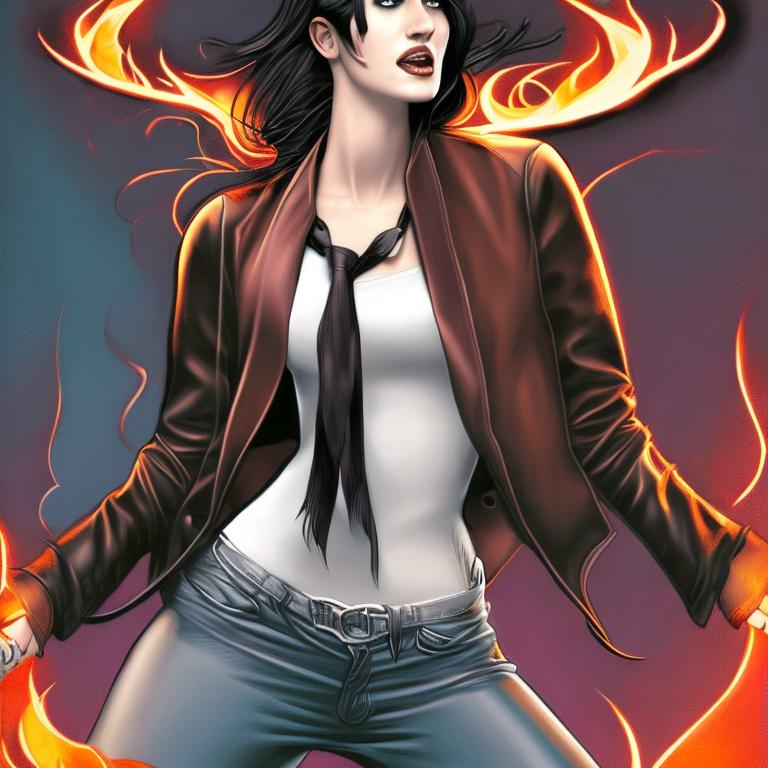

Prompt: Rafael Albuquerque comic cover art, artgerm, Joshua Middleton, pretty Eva Green vampire, sharp vampire teeth, sarcastic smile, symmetrical eyes, symmetrical face, brown leather jacket, jeans, long black hair, full body, building on fire, cool colors


In [22]:
# Get a random index from the DataFrame
random_index = random.randint(0, len(df_80k) - 1)

# Get the random image path and prompt
random_image_path = df_80k.loc[random_index, 'image_path']
random_prompt = df_80k.loc[random_index, 'Prompt']

# Load and display the random image
random_image = Image.open(random_image_path)
display(random_image)

# Print the corresponding prompt
print(f"Prompt: {random_prompt}")

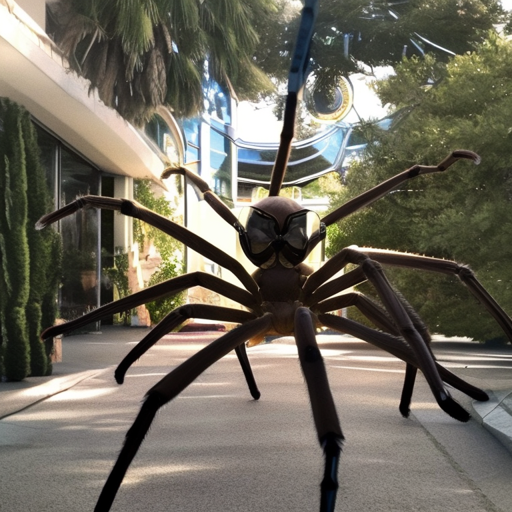

Prompt: walter white as a giant spider, 4 k, award winning photo iphone photo iphones 1 3. 4 iphone photo, zoomed out iphone picture iphone iphone picture taken with nikon dslr camera iphone on iphone  on instagram iphone  in the background 


In [37]:
# Read your dataset into a DataFrame
gpt_generated_prompts_df = pd.read_csv('H:/585pj/gpt_generated_images/gpt_generated_prompts.csv')

def create_image_path(index):
    base_path = 'H:/585pj/gpt_generated_images/gpt_generated_images/'
    return f"{base_path}{index}.png"

# Add a new column 'image_path' to the DataFrame
gpt_generated_prompts_df['image_path'] = gpt_generated_prompts_df.index.map(create_image_path)

# Get a random index from the DataFrame
random_index = random.randint(0, len(gpt_generated_prompts_df) - 1)

# Get the random image path and prompt
random_prompt = gpt_generated_prompts_df.loc[random_index, 'prompt']
random_image_path = gpt_generated_prompts_df.loc[random_index, 'image_path']

# Load and display the random image
random_image = Image.open(random_image_path)
display(random_image)

# Print the corresponding prompt
print(f"Prompt: {random_prompt}")

In [31]:
df_filtered=pd.read_csv('H:/585pj/df_filtered.csv')
df_filtered.head()

,image_name,prompt,width,height,filepath,index
0,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",512,512,H:/585pj/DDB_2M/images/dc71658a-5e4b-4dca-861a-e1535510348b.png,2
1,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,512,768,H:/585pj/DDB_2M/images/601d9792-eccd-4850-97a7-edbe91d3464c.png,4
2,3c586acb-14dc-43df-8900-954c336f01b3.png,a dog doing weights on fire. epic oil painting.,512,768,H:/585pj/DDB_2M/images/3c586acb-14dc-43df-8900-954c336f01b3.png,5
3,2919b048-6f68-4ac7-a6d5-060d827abb77.png,"a beautiful paint of cultists dancing surrounds a huge alpaca in desert at night, by zdzislaw beksinski, trending on artstation.",512,512,H:/585pj/DDB_2M/images/2919b048-6f68-4ac7-a6d5-060d827abb77.png,7
4,454d7550-a6cf-4896-befb-e2449b281265.png,"a stunning portrait of an asian samurai with long black hair by artgerm, dynamic lighting, ray tracing, tom bagshaw, alphonse mucha, donata giancola, mary jane ansell, ankh necklace, atmosphere, realism, octane render, dof, hyperdetailed, 8 k",512,512,H:/585pj/DDB_2M/images/454d7550-a6cf-4896-befb-e2449b281265.png,10


In [32]:
df_80k.head()

,Prompt,image_path
0,"realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field,",H:/585pj/80k/images/00000000.jpg
1,"a comic potrait of a female necromamcer with big and cute eyes, fine - face, realistic shaded perfect face, fine details. night setting. very anime style. realistic shaded lighting poster by ilya kuvshinov katsuhiro, magali villeneuve, artgerm, jeremy lipkin and michael garmash, rob rey and kentaro miura style, trending on art station",H:/585pj/80k/images/00000001.jpg
2,"steampunk market interior, colorful, 3 d scene, greg rutkowski, zabrocki, karlkka, jayison devadas, trending on artstation, 8 k, ultra wide angle, zenith view, pincushion lens effect",H:/585pj/80k/images/00000002.jpg
3,"“A portrait of a cyborg in a golden suit, D&D sci-fi, artstation, concept art, highly detailed illustration.”",H:/585pj/80k/images/00000003.jpg
4,"A full portrait of a beautiful post apocalyptic offworld nanotechnician, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by Krenz Cushart and Artem Demura and alphonse mucha",H:/585pj/80k/images/00000004.jpg


In [47]:
combined_df.describe()

,prompt,file_path
count,837719,837719
unique,808687,837719
top,greg rutkowski and alphonse mucha,H:/585pj/gpt_generated_images/gpt_generated_images/0.png
freq,5,1


In [48]:
# Ensure the column names match
gpt_generated_prompts_df.columns = ['prompt', 'file_path']
df_80k.columns = ['prompt', 'file_path']
df_filtered = df_filtered.rename(columns={'filepath': 'file_path'})

# Select only the relevant columns
gpt_generated_prompts_df = gpt_generated_prompts_df[['prompt', 'file_path']]
df_80k = df_80k[['prompt', 'file_path']]
df_filtered = df_filtered[['prompt', 'file_path']]

# Combine the DataFrames
combined_df = pd.concat([gpt_generated_prompts_df, df_80k, df_filtered], ignore_index=True)

# Rename the columns in the combined DataFrame
combined_df.columns = ['prompt', 'file_path']

# Save the combined DataFrame to a CSV file
combined_df.to_csv('H:/585PJ/combined_dataframe.csv', index=False)

In [12]:

"""add your image paths and embedding labels here"""
encoder = SentenceTransformer('all-MiniLM-L6-v2')
encoder = encoder.to('cuda')
#train data is df_filtered.csv, train_images'path is in column 'filepath', train_labels is in column 'prompt'
#test data is test.csv, test_images'path is in column 'image_path', test_labels is in column 'Prompt'



In [3]:
train_data = pd.read_csv('combined_dataframe.csv')


In [ ]:
test_images = df_test['image_path']
test_labels = df_test['Prompt']
test_labels=encoder.encode(df_test['Prompt'].tolist(), batch_size=512, show_progress_bar=True, device="cuda", convert_to_tensor=True)
test_labels = torch.load('test_targets.pt').cpu().numpy()

In [14]:
train_images = train_data['file_path']
train_labels = train_data['prompt']
train_labels=encoder.encode(train_data['prompt'].tolist(), batch_size=512, show_progress_bar=True, device="cuda", convert_to_tensor=True)
test_images = df_test['image_path']
test_labels = df_test['Prompt']
test_labels=encoder.encode(df_test['Prompt'].tolist(), batch_size=512, show_progress_bar=True, device="cuda", convert_to_tensor=True)

# Save the encoded labels as tensor files
torch.save(train_labels, 'train_targets.pt')
torch.save(test_labels, 'test_targets.pt')

Batches:   0%|          | 0/1637 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
df_test.to_csv('H:/585pj/test.csv',index=False)